In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [11]:
df = pd.read_csv("tweet_data.csv")
df = df.sample(frac=1).reset_index(drop=True)
df['Text'] = df['Text'].apply(lambda x: x.lower())  # transform text to lowercase
df['Text'] = df['Text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
print(df.shape)
df.head(10)

(5791, 2)


,Text,Sentiment
0,aap could buy back 100m shares for 40b saving ...,1
1,equity alpha twtc looks like great short under...,-1
2,aap now 400 glass ceiling 4345 rejecting bot...,-1
3,agree user hedge funds sold aap in q4 well see...,1
4,nov breaking the dt this time volume looking m...,1
5,hd bullish after its results ong if beats 6724...,1
6,aap follow the downtrend,-1
7,cen just giving everybody more buying opp imho...,1
8,jpm broke out an important resistance at 4687 ...,1
9,po swing trade quick pick polyone corp po,1


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


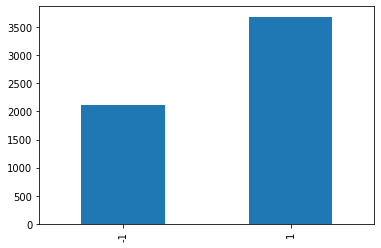

In [12]:
df['Sentiment'].value_counts().sort_index().plot.bar()

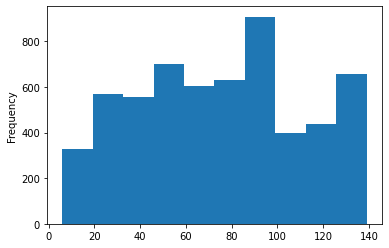

In [13]:

df['Text'].str.len().plot.hist()

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Text'].values)
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X)
print("X tokenized data = ", X[:5])

X tokenized data =  [[   0    0    0    0    0    0    0    0    8   85   56   55 3241  150
     7 4809 4810 4811  717 4812  649 2064    4  291  108  128  432  718
     2 1381 2528]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  931 1120 4813   97   29  142   16  119 3242  449 4814
  4815  449  762]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    8   35  547 2529 2530 3243 4816  329 3244
     9   35 4817]
 [   0    0    0  932   11  650  490  263    8    5  825  130   64   34
    13   78    3  933   58   75  110 4818    1   39    5    3 1011   15
   339    1 3245]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 1012  151    1  719   14   76   28   87
   189   43 4819]]


In [15]:
y = pd.get_dummies(df['Sentiment']).values
[print(df['Sentiment'][i], y[i]) for i in range(0, 5)]

1 [0 1]
-1 [1 0]
-1 [1 0]
1 [0 1]
1 [0 1]


[None, None, None, None, None]

In [16]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(GRU(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 31, 256)           0         
                                                                 
 gru (GRU)                   (None, 31, 256)           394752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 2,070,018
Trainable params: 2,070,018
Non-trainable params: 0
_________________________________________________________________


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [19]:
batch_size = 32
epochs = 8

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)


Epoch 1/8
145/145 - 80s - loss: 0.5800 - accuracy: 0.6978 - 80s/epoch - 553ms/step
Epoch 2/8
145/145 - 77s - loss: 0.3669 - accuracy: 0.8396 - 77s/epoch - 530ms/step
Epoch 3/8
145/145 - 74s - loss: 0.2355 - accuracy: 0.9054 - 74s/epoch - 514ms/step
Epoch 4/8
145/145 - 77s - loss: 0.1370 - accuracy: 0.9443 - 77s/epoch - 531ms/step
Epoch 5/8
145/145 - 77s - loss: 0.0823 - accuracy: 0.9678 - 77s/epoch - 534ms/step
Epoch 6/8
145/145 - 75s - loss: 0.0542 - accuracy: 0.9825 - 75s/epoch - 515ms/step
Epoch 7/8
145/145 - 77s - loss: 0.0386 - accuracy: 0.9883 - 77s/epoch - 530ms/step
Epoch 8/8
145/145 - 74s - loss: 0.0414 - accuracy: 0.9864 - 74s/epoch - 514ms/step


In [20]:
predictions = model.predict(X_test)

In [21]:
pos_count, neg_count = 0, 0
real_pos, real_neg = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==1:
        pos_count += 1
    else:
        neg_count += 1
    if np.argmax(y_test[i])==1:    
        real_pos += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Negative predictions:', neg_count)

print('Real neutral:', real_pos)
print('Real negative:', real_neg)

Positive predictions: 764
Negative predictions: 395
Real neutral: 755
Real negative: 404


In [22]:
import matplotlib.pyplot as plt

print(history.history['loss'], )
predictions = [pos_count, neg_count]
real = [real_pos, real_neg]
labels = ['Positive', 'Negative']

[0.5799645781517029, 0.36693495512008667, 0.2354692816734314, 0.13701769709587097, 0.08231723308563232, 0.05419052392244339, 0.03857928514480591, 0.04137023910880089]


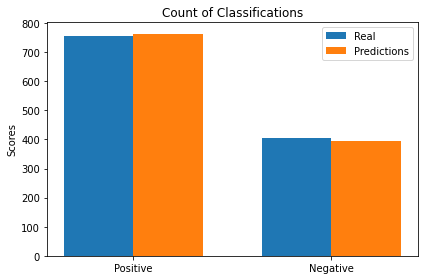

In [23]:
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, predictions, width, label='Predictions')

ax.set_ylabel('Scores')
ax.set_title('Count of Classifications')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

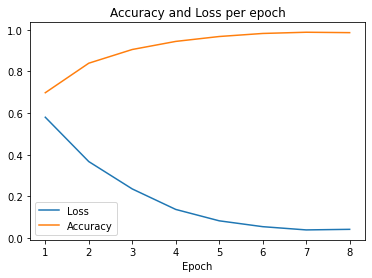

In [24]:
fig, ax = plt.subplots()
loss = history.history['loss']
epoch = [item for item in range(1,9)]
accuracy = history.history['accuracy']
ax.plot(epoch, loss, label = "Loss")
ax.plot(epoch, accuracy, label = "Accuracy")

ax.set_xlabel('Epoch')
ax.set_title('Accuracy and Loss per epoch')
plt.legend()
plt.show()